# Maternal Mortality Prediction in Kenyan Hospitals

This notebook analyzes data on maternal mortality (deaths of women during childbirth) across different hospitals in Kenya. We'll build a predictive model to forecast mortality rates based on hospital characteristics and other factors.




# Install required packages


In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn streamlit

# Imports and Configuration
# Setting up our environment with necessary libraries and configurations.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
# ## Data Generation
# Since we don't have actual data, we'll generate synthetic data that mimics real-world maternal mortality statistics across hospitals.
# Generate synthetic data for maternal mortality across hospitals
n_hospitals = 100

# Hospital features
data = {
    'hospital_id': range(1, n_hospitals + 1),
    'beds': np.random.randint(50, 1000, n_hospitals),
    'doctors_per_patient': np.random.uniform(0.05, 0.3, n_hospitals),
    'nurses_per_patient': np.random.uniform(0.1, 0.8, n_hospitals),
    'equipment_quality': np.random.uniform(1, 10, n_hospitals),
    'rural_location': np.random.choice([0, 1], n_hospitals, p=[0.7, 0.3]),
    'avg_patient_age': np.random.normal(29, 5, n_hospitals),
    'avg_pregnancies_per_patient': np.random.normal(2.1, 1, n_hospitals),
    'has_nicu': np.random.choice([0, 1], n_hospitals, p=[0.4, 0.6]),
    'hospital_years': np.random.randint(1, 100, n_hospitals)
}

In [5]:
# Create DataFrame
df = pd.DataFrame(data)

# Generate target variable (maternal mortality per 1000 births)
# Base rate influenced by hospital characteristics
base_rate = 0.5 + (10 - df['equipment_quality']) * 0.3 + df['rural_location'] * 0.8 - df['doctors_per_patient'] * 5 - df['nurses_per_patient'] * 2 + (df['avg_patient_age'] - 25) * 0.1 - df['has_nicu'] * 0.7

In [6]:
# Add some noise
df['mortality_rate'] = np.maximum(0.1, base_rate + np.random.normal(0, 0.5, n_hospitals))

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (100, 11)


,hospital_id,beds,doctors_per_patient,nurses_per_patient,equipment_quality,rural_location,avg_patient_age,avg_pregnancies_per_patient,has_nicu,hospital_years,mortality_rate
0,1,152,0.280469,0.269439,6.011211,0,27.488379,4.155093,1,57,0.100000
1,2,485,0.072123,0.570495,9.425393,0,28.977186,1.780640,0,1,0.100000
2,3,910,0.098996,0.633134,7.264268,0,25.588287,1.653317,1,63,0.100000
3,4,320,0.061307,0.266346,6.130551,1,28.759023,1.624329,1,54,0.911177
4,5,156,0.131333,0.609751,1.874588,0,35.355691,1.284501,1,55,1.352416


In [7]:
# Exploratory Data Analysis
#
# Let's explore the relationships between hospital characteristics and maternal mortality rates.

# Basic statistics
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
       hospital_id        beds  doctors_per_patient  nurses_per_patient  \
count   100.000000  100.000000           100.000000          100.000000   
mean     50.500000  496.280000             0.168069            0.456440   
std      29.011492  270.410055             0.074711            0.205795   
min       1.000000   51.000000             0.051381            0.103543   
25%      25.750000  261.750000             0.107146            0.269403   
50%      50.500000  494.500000             0.156831            0.486377   
75%      75.250000  732.250000             0.240833            0.612950   
max     100.000000  992.000000             0.296722            0.781107   

       equipment_quality  rural_location  avg_patient_age  \
count         100.000000      100.000000       100.000000   
mean            5.414191        0.380000        29.601772   
std             2.526072        0.487832         4.880136   
min             1.129541        0.000000        16.738677   

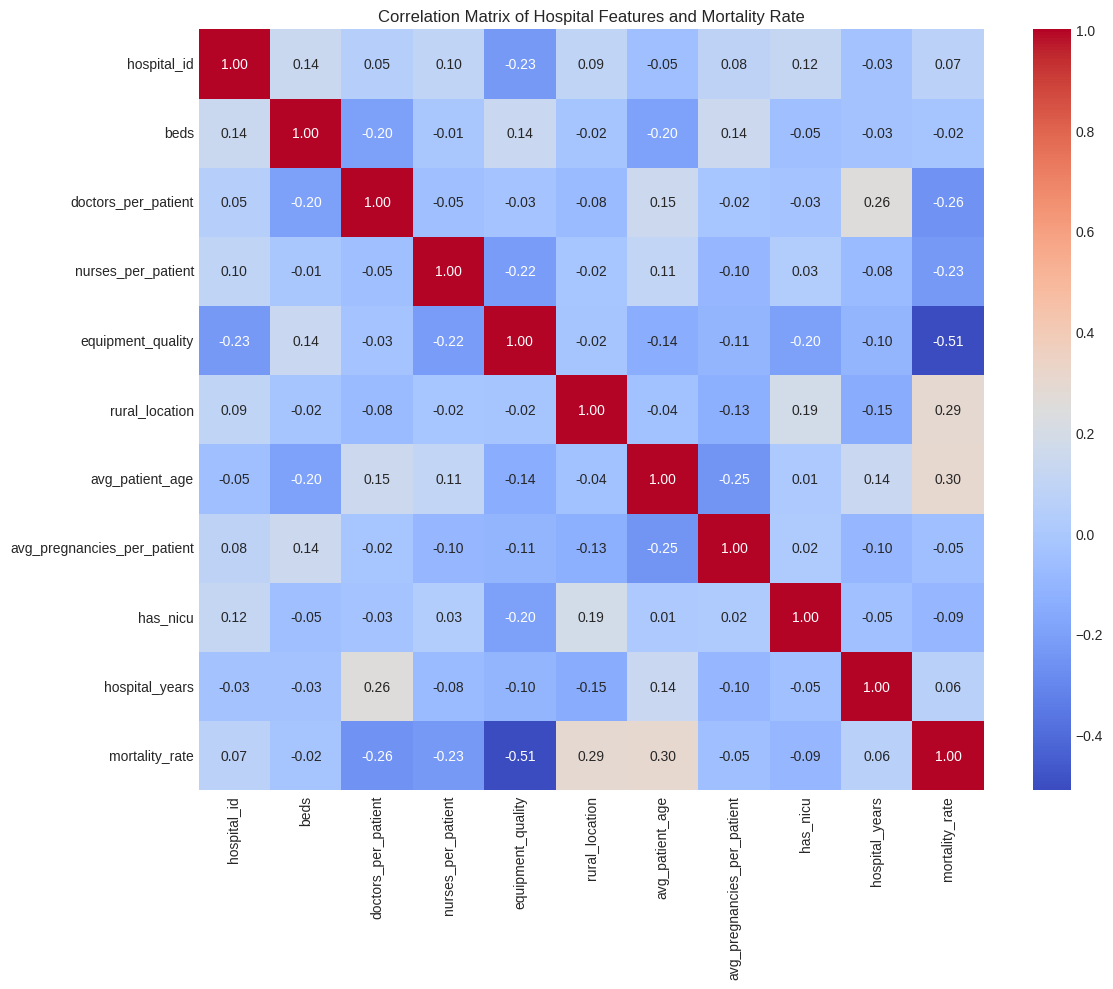

In [8]:
# Correlation analysis
plt.figure(figsize=(12, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hospital Features and Mortality Rate')
plt.tight_layout()

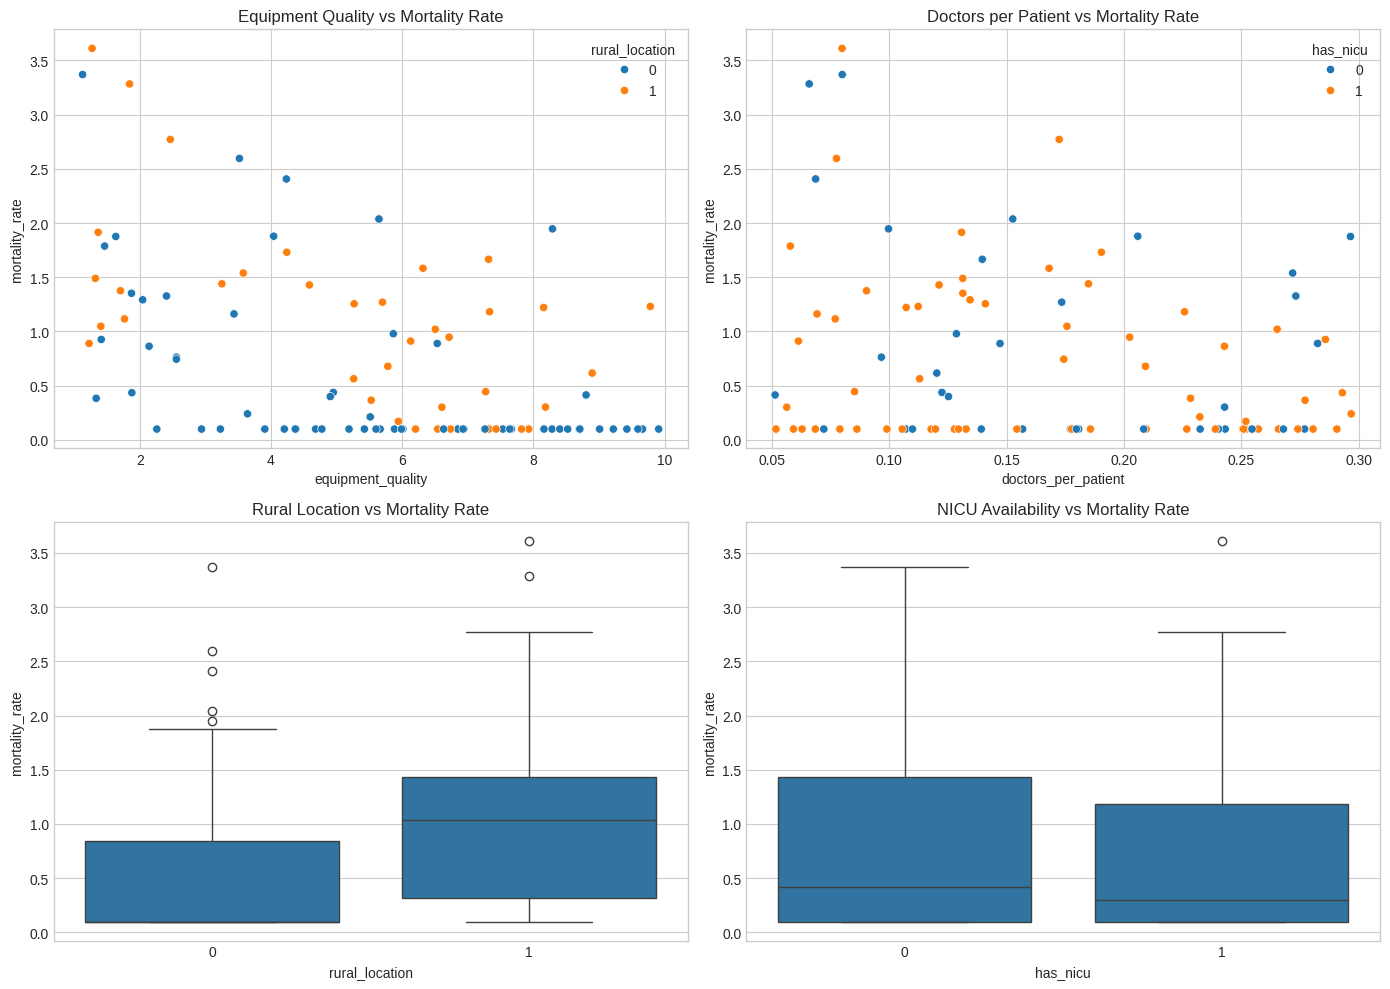

In [9]:
# Key feature relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(x='equipment_quality', y='mortality_rate', hue='rural_location',
                data=df, ax=axes[0, 0])
axes[0, 0].set_title('Equipment Quality vs Mortality Rate')

sns.scatterplot(x='doctors_per_patient', y='mortality_rate', hue='has_nicu',
                data=df, ax=axes[0, 1])
axes[0, 1].set_title('Doctors per Patient vs Mortality Rate')

sns.boxplot(x='rural_location', y='mortality_rate', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Rural Location vs Mortality Rate')

sns.boxplot(x='has_nicu', y='mortality_rate', data=df, ax=axes[1, 1])
axes[1, 1].set_title('NICU Availability vs Mortality Rate')

plt.tight_layout()
plt.show()

In [10]:
# ## Data Preprocessing
#
# Prepare the data for modeling by splitting into training and testing sets and scaling features.

# Prepare features and target
X = df.drop(['hospital_id', 'mortality_rate'], axis=1)
y = df['mortality_rate']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (80, 9)
Testing set shape: (20, 9)


In [11]:
# Model Building and Training
#
# We'll use a Random Forest Regressor to predict maternal mortality rates based on hospital characteristics.

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model Performance:
Mean Squared Error: 0.2107
Root Mean Squared Error: 0.4590
R² Score: 0.7281


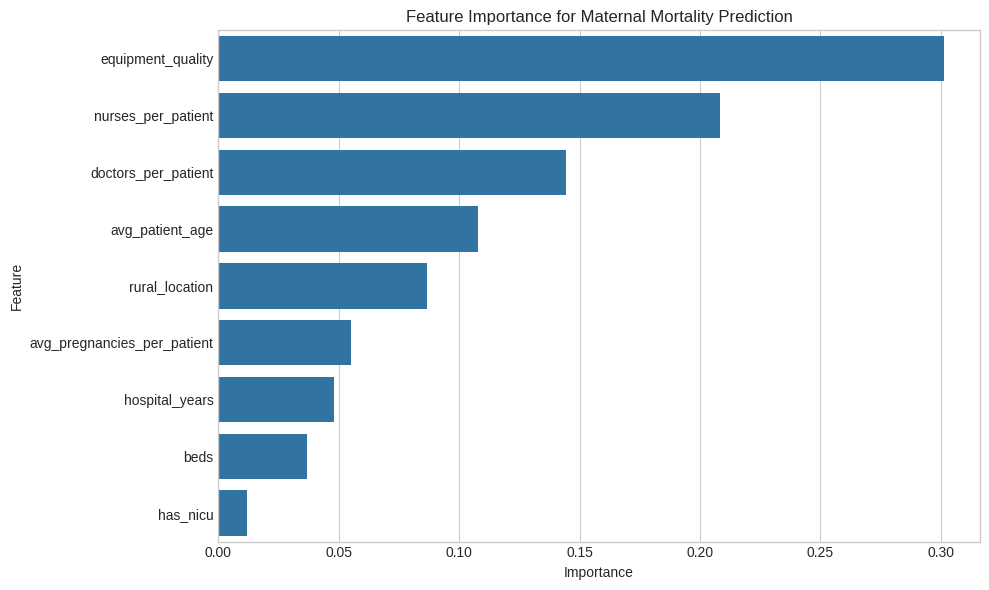

In [12]:
# ## Feature Importance Analysis
#
# Let's examine which hospital characteristics have the strongest influence on maternal mortality rates.

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Maternal Mortality Prediction')
plt.tight_layout()

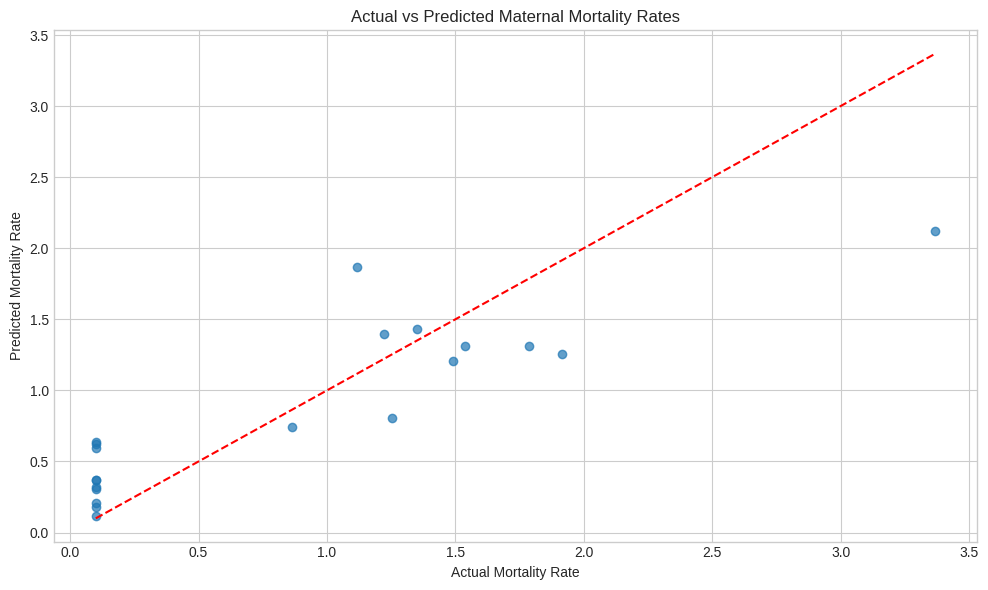

In [13]:
# Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Mortality Rate')
plt.ylabel('Predicted Mortality Rate')
plt.title('Actual vs Predicted Maternal Mortality Rates')
plt.tight_layout()
plt.show()

# ## Prediction for New Hospitals
#
# Let's create a function to predict mortality rates for new hospitals based on their characteristics.

# Function to predict mortality rate for new hospitals
def predict_mortality(hospital_data):
    """
    Predict maternal mortality rate for new hospital data

    Parameters:
    hospital_data (dict): Dictionary with hospital characteristics

    Returns:
    float: Predicted mortality rate
    """
    # Convert to DataFrame
    new_data = pd.DataFrame([hospital_data])

    # Ensure all required columns are present
    for col in X.columns:
        if col not in new_data.columns:
            raise ValueError(f"Missing required feature: {col}")

    # Select and order columns to match training data
    new_data = new_data[X.columns]

    # Scale the data
    new_data_scaled = scaler.transform(new_data)

    # Make prediction
    prediction = model.predict(new_data_scaled)[0]

    return prediction
# Example usage
new_hospital = {
    'beds': 350,
    'doctors_per_patient': 0.15,
    'nurses_per_patient': 0.4,
    'equipment_quality': 7.5,
    'rural_location': 0,
    'avg_patient_age': 28,
    'avg_pregnancies_per_patient': 2.0,
    'has_nicu': 1,
    'hospital_years': 25
}

In [14]:
predicted_rate = predict_mortality(new_hospital)
print(f"Predicted maternal mortality rate: {predicted_rate:.2f} per 1000 births")

Predicted maternal mortality rate: 0.17 per 1000 births


In [15]:
# Save trained model
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [16]:
import streamlit as st

st.title("Maternal Mortality Rate Predictor")

beds = st.slider("Number of Beds", 50, 1000, 350)
1234567891011121314151617181920212223
import streamlit as st

st.title("Maternal Mortality Rate Predictor")

beds = st.slider("Number of Beds", 50, 1000, 350)
doctors = st.slider("Doctors per Patient", 0.05, 0.3, 0.15)
nurses = st.slider("Nurses per Patient", 0.1, 0.8, 0.4)
# equipment = st.slider("Equipment Quality", 1, 10, 7.5)
equipment = st.slider("Equipment Quality", 1.0, 10.0, 7.5, 0.1)
rural = st.selectbox("Is it a Rural Location?", [0, 1])
nicu = st.selectbox("Has NICU?", [0, 1])

12345678910111213141516171819202122

doctors = st.slider("Doctors per Patient", 0.05, 0.3, 0.15, 0.01) # Added step for float
nurses = st.slider("Nurses per Patient", 0.1, 0.8, 0.4, 0.01) # Added step for float
equipment = st.slider("Equipment Quality", 1.0, 10.0, 7.5, 0.1) # Changed min/max to float and added step


rural = st.selectbox("Is it a Rural Location?", [0, 1])
nicu = st.selectbox("Has NICU?", [0, 1])
age = st.slider("Average Patient Age", 18, 45, 28)
pregnancies = st.slider("Avg Pregnancies per Patient", 0.5, 5.0, 2.0, 0.1) # Added step for float
years = st.slider("Hospital Age (Years)", 1, 100, 25)

if st.button("Predict"):
    input_data = {
        'beds': beds, 'doctors_per_patient': doctors, 'nurses_per_patient': nurses,
        'equipment_quality': equipment, 'rural_location': rural, 'avg_patient_age': age,
        'avg_pregnancies_per_patient': pregnancies, 'has_nicu': nicu, 'hospital_years': years
    }
    rate = predict_mortality(input_data)
    st.success(f"Predicted Maternal Mortality Rate: {rate:.2f} per 1000 births")

2025-07-26 17:12:27.746 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 17:12:28.391 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-26 17:12:28.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 17:12:28.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 17:12:28.405 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 17:12:28.409 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 17:12:28.413 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 17:12:28.418 Thread 'MainThread': mi

In [17]:
# Save the Streamlit code to a Python file
streamlit_code = """
import streamlit as st
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Assuming your model and scaler are saved as 'random_forest_model.pkl' and 'scaler.pkl'
# You would typically load them here. Since we generated data and trained in the notebook,
# we will define the predict_mortality function directly.

# In a real application, you would load the model and scaler like this:
# model = joblib.load('random_forest_model.pkl')
# scaler = joblib.load('scaler.pkl')

# For this example, we'll use the function defined in the notebook.
# Make sure the 'predict_mortality', 'model' and 'scaler' objects are available in the Colab environment

st.title("Maternal Mortality Rate Predictor")

beds = st.slider("Number of Beds", 50, 1000, 350)
doctors = st.slider("Doctors per Patient", 0.05, 0.3, 0.15, 0.01)
nurses = st.slider("Nurses per Patient", 0.1, 0.8, 0.4, 0.01)
equipment = st.slider("Equipment Quality", 1.0, 10.0, 7.5, 0.1)
rural = st.selectbox("Is it a Rural Location?", [0, 1])
nicu = st.selectbox("Has NICU?", [0, 1])
age = st.slider("Average Patient Age", 18, 45, 28)
pregnancies = st.slider("Avg Pregnancies per Patient", 0.5, 5.0, 2.0, 0.1)
years = st.slider("Hospital Age (Years)", 1, 100, 25)

if st.button("Predict"):
    input_data = {
        'beds': beds, 'doctors_per_patient': doctors, 'nurses_per_patient': nurses,
        'equipment_quality': equipment, 'rural_location': rural, 'avg_patient_age': age,
        'avg_pregnancies_per_patient': pregnancies, 'has_nicu': nicu, 'hospital_years': years
    }
    # Assuming predict_mortality function is available in the environment
    rate = predict_mortality(input_data)
    st.success(f"Predicted Maternal Mortality Rate: {rate:.2f} per 1000 births")
"""

with open("app.py", "w") as f:
    f.write(streamlit_code)

Now, run the following command in a new cell to start the Streamlit app. You will get a public URL to access the app.

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼

⠴⠦⠧⠇⠏
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.84.184:8501

⠋⠙⠹⠸⠼your url is: https://deep-donkeys-change.loca.lt
